In [18]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

crop_production = spark.read.csv("crop_production.csv", header=True, inferSchema=True)
rainfall = spark.read.csv("rainfall.csv", header=True, inferSchema=True)

crop_production = crop_production.withColumnRenamed("Crop_Year", "YEAR")

joined_data = crop_production.join(rainfall, on=["State_Name", "YEAR"], how="inner")

# joined_data.select('State_Name', 'YEAR', 'District_Name', 'Season', 'Crop', 'Area', 'ANNUAL', 'Production').toPandas().to_csv('final_data.csv')

joined_data.select('State_Name', 'YEAR', 'District_Name', 'Season', 'Crop', 'Area', 'ANNUAL', 'Production').show()

+--------------------+----+-------------+-----------+-------------------+-------+------+----------+
|          State_Name|YEAR|District_Name|     Season|               Crop|   Area|ANNUAL|Production|
+--------------------+----+-------------+-----------+-------------------+-------+------+----------+
|Andaman and Nicob...|2000|     NICOBARS|Kharif     |           Arecanut| 1254.0|2763.2|    2000.0|
|Andaman and Nicob...|2000|     NICOBARS|Kharif     |Other Kharif pulses|    2.0|2763.2|       1.0|
|Andaman and Nicob...|2000|     NICOBARS|Kharif     |               Rice|  102.0|2763.2|     321.0|
|Andaman and Nicob...|2000|     NICOBARS|Whole Year |             Banana|  176.0|2763.2|     641.0|
|Andaman and Nicob...|2000|     NICOBARS|Whole Year |          Cashewnut|  720.0|2763.2|     165.0|
|Andaman and Nicob...|2000|     NICOBARS|Whole Year |           Coconut |18168.0|2763.2|    6.51E7|
|Andaman and Nicob...|2000|     NICOBARS|Whole Year |         Dry ginger|   36.0|2763.2|     100.0|


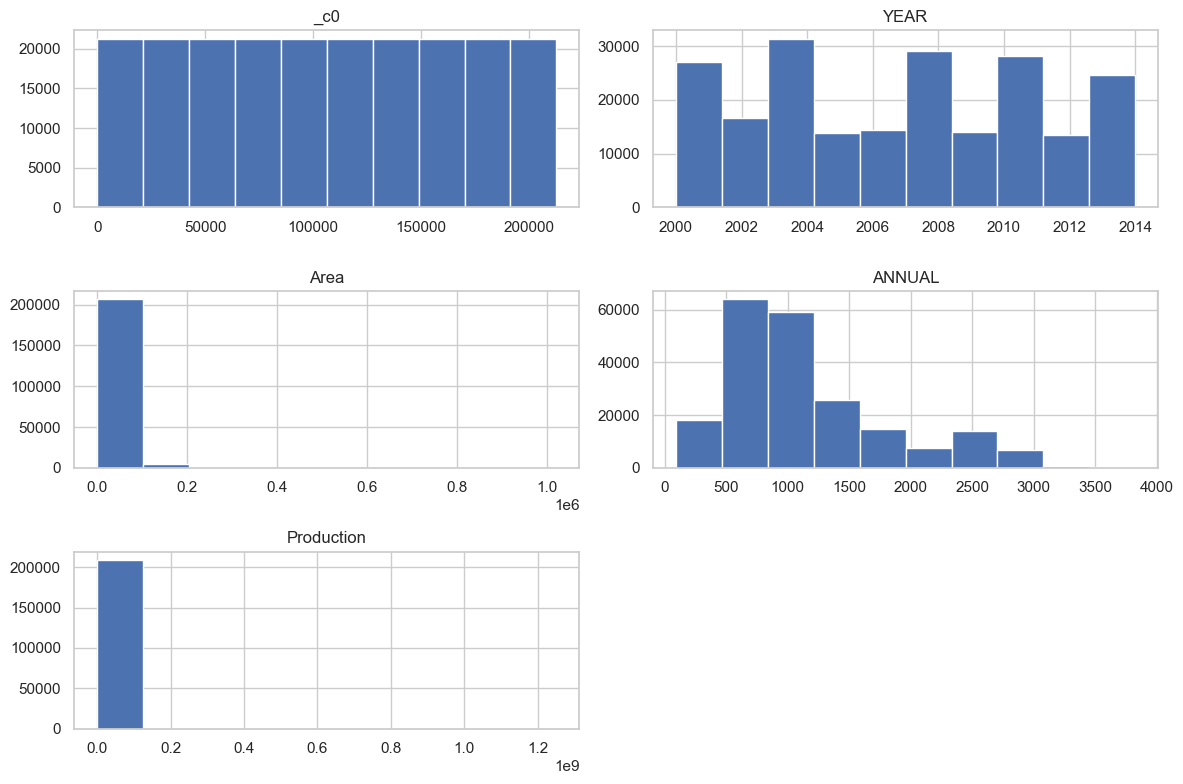

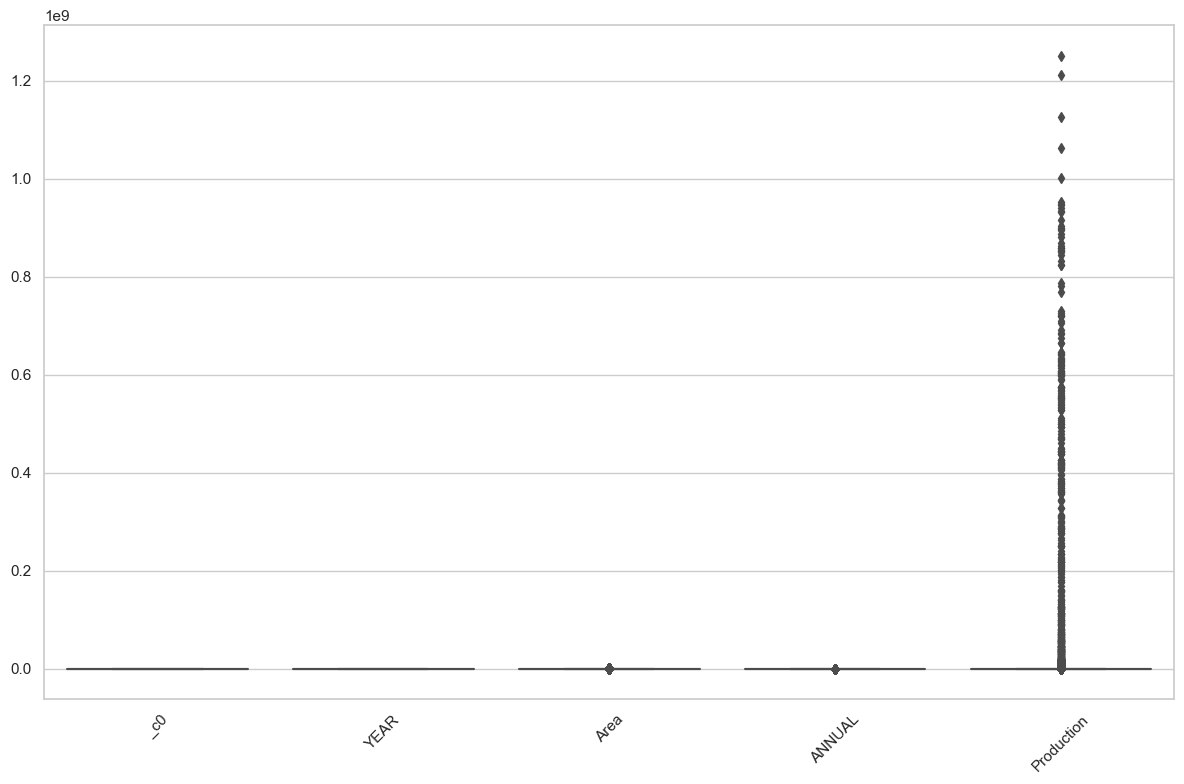

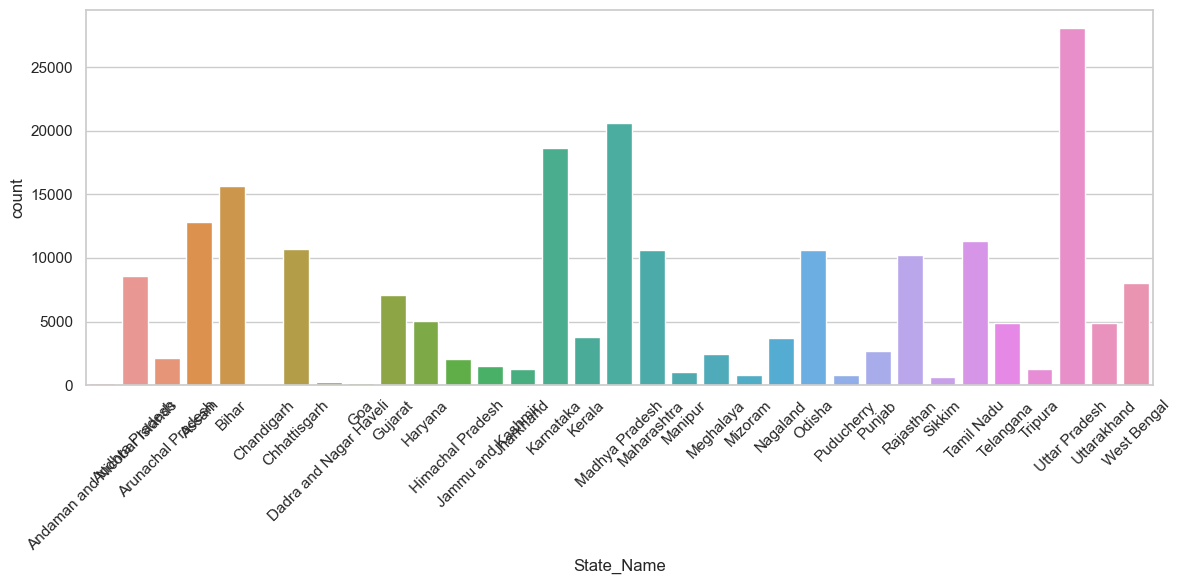

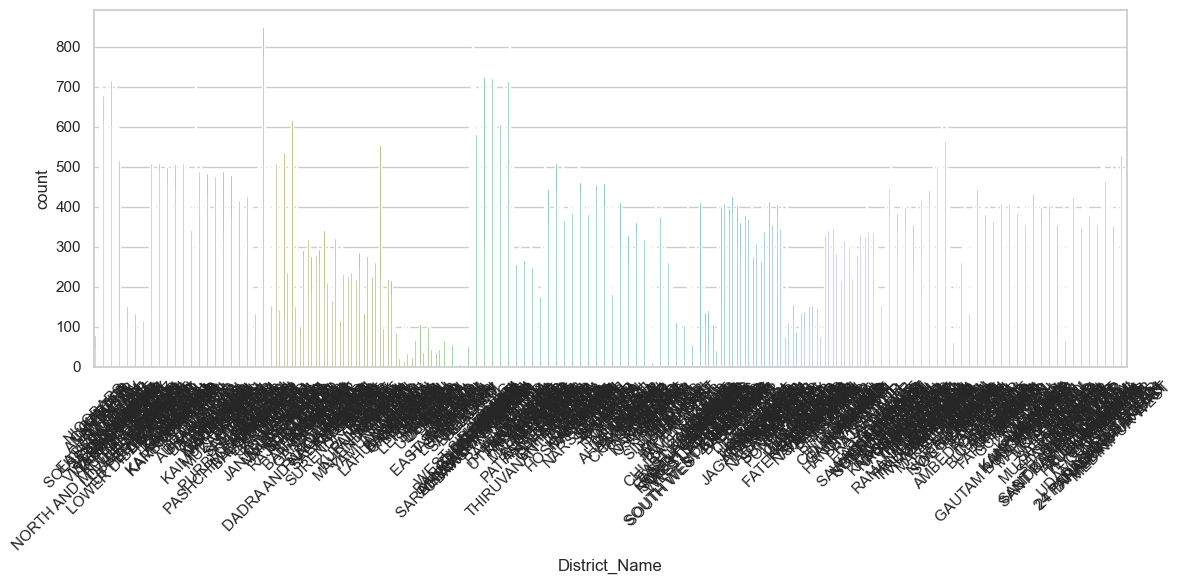

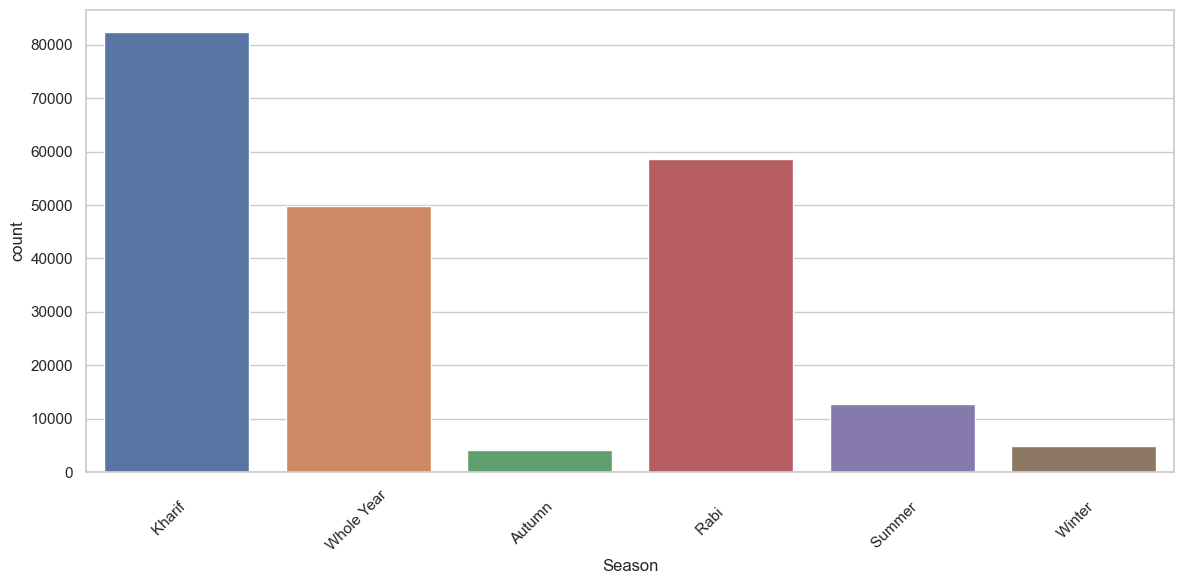

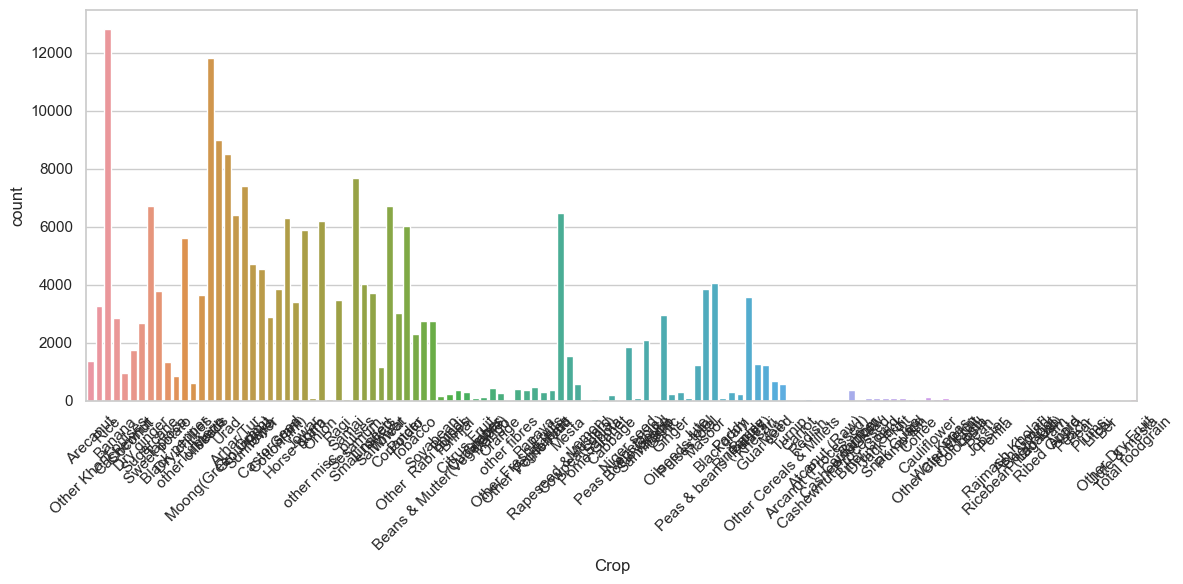

C:\Users\dgoya\AppData\Local\Temp\ipykernel_11000\419858173.py:33: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data_pd.corr()


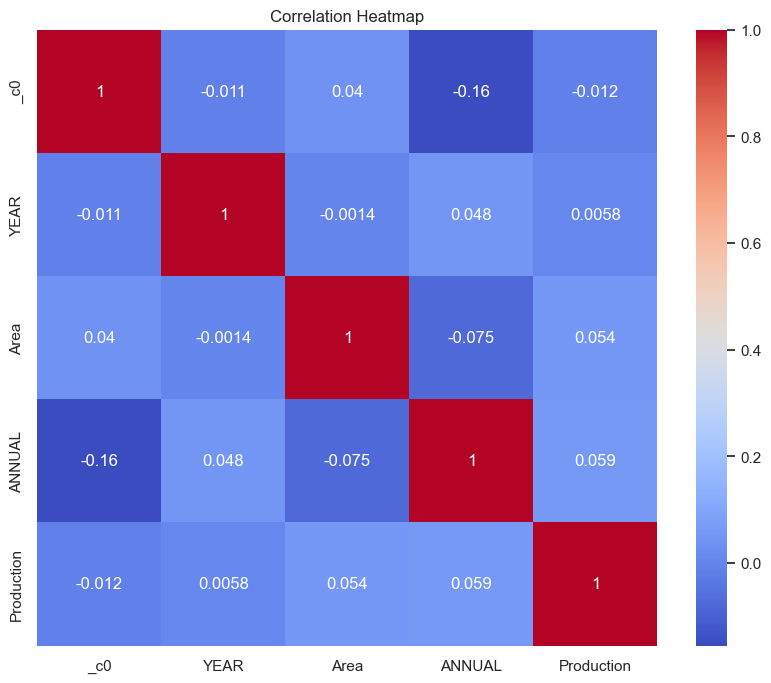

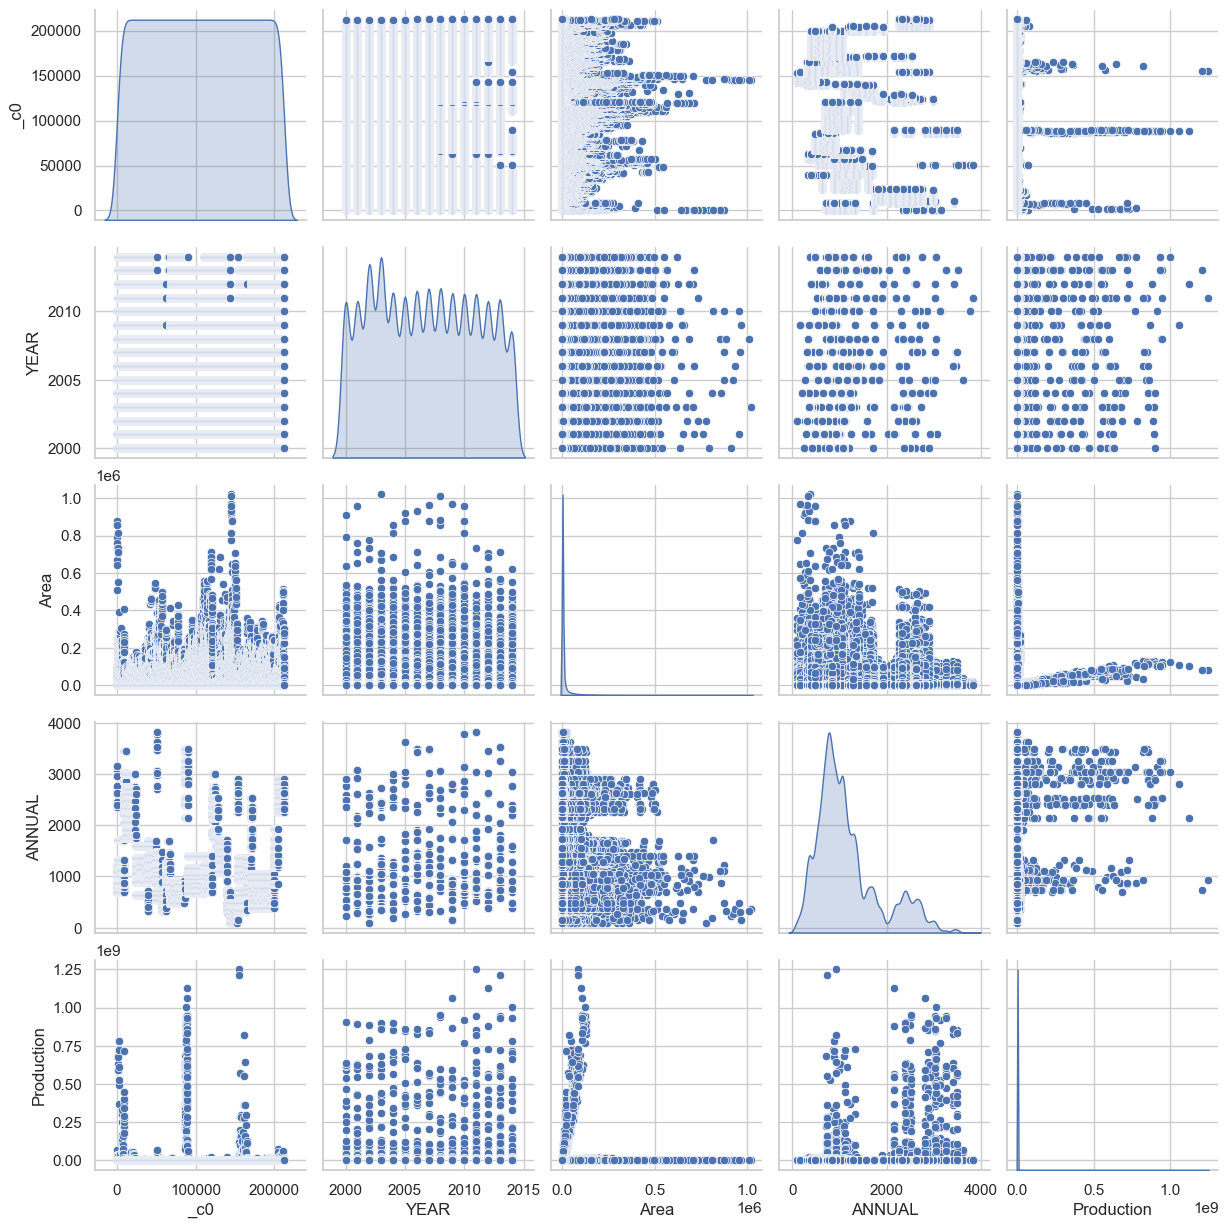

In [36]:
import seaborn as sns

# Load the data
data = spark.read.csv("final_data.csv", header=True, inferSchema=True)
data = data.withColumn("ANNUAL", col("ANNUAL").cast("double"))

# Data visualization using pandas and seaborn
data_pd = data.toPandas()

# Histograms
data_pd.hist(figsize=(12, 8))
plt.tight_layout()
plt.show()

# Box plots
plt.figure(figsize=(12, 8))
sns.boxplot(data=data_pd)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bar plots for categorical variables
categorical_vars = ['State_Name', 'District_Name', 'Season', 'Crop']
for col in categorical_vars:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=data_pd, x=col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = data_pd.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Pair plots (use with caution if you have many features)
sns.pairplot(data_pd, diag_kind="kde")
plt.show()


Linear Regression RMSE: 14985268.687690603
Random Forest RMSE: 4011762.1589053688
Gradient Boosting RMSE: 4372937.842218238
Decision Tree RMSE: 4986906.107707072


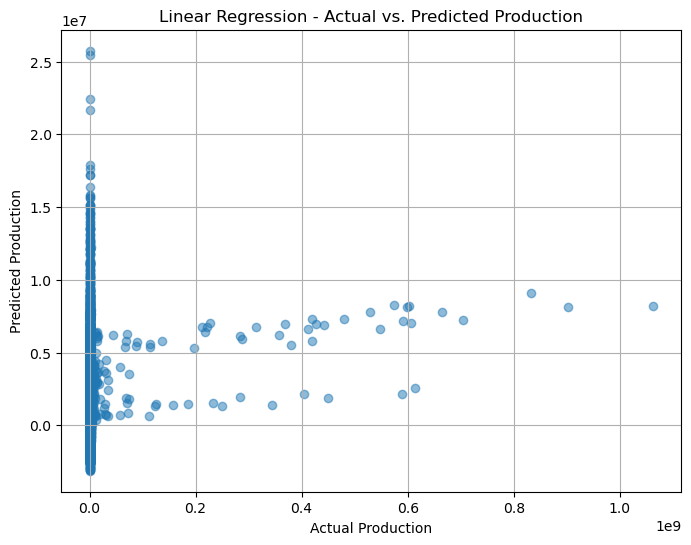

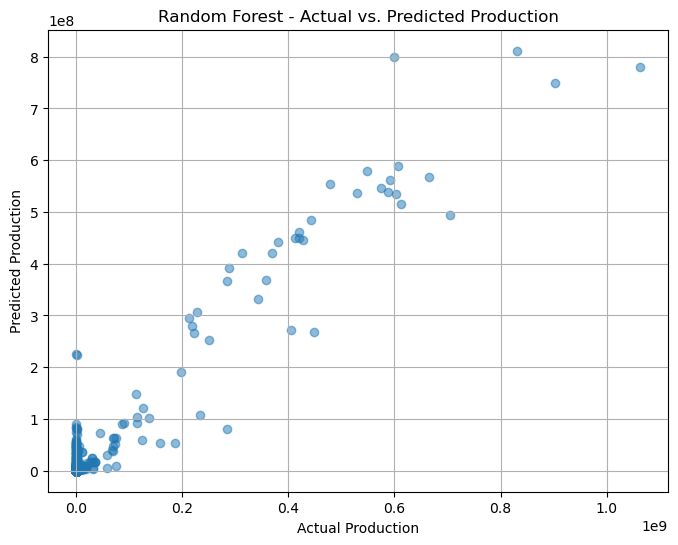

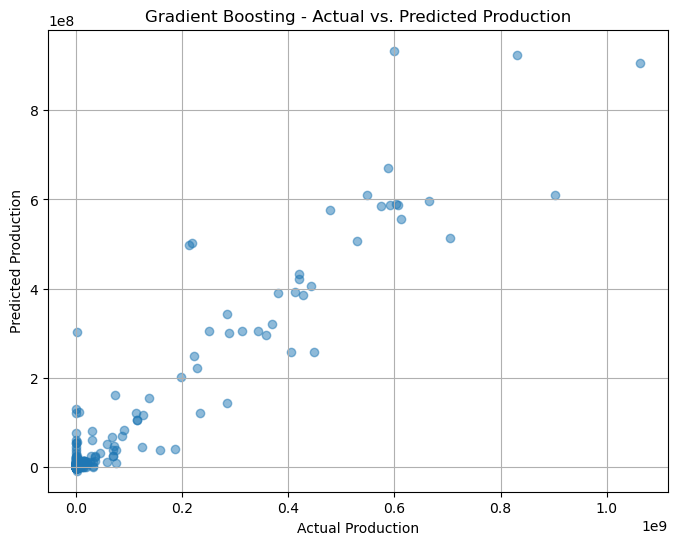

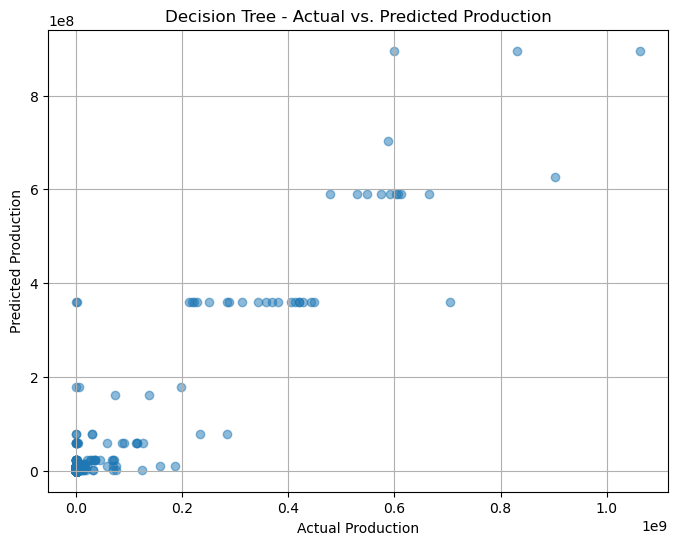

In [34]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor, DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# Initialize Spark session
spark = SparkSession.builder.appName("MLAnalysis").getOrCreate()

# Load the data
data = spark.read.csv("final_data.csv", header=True, inferSchema=True)

data = data.withColumn("ANNUAL", col("ANNUAL").cast("double"))

# Prepare data: Handle missing values and convert categorical features
data = data.fillna(0, subset=['Production', 'Area', 'ANNUAL'])  # Assuming 'Production', 'Area', and 'ANNUAL' are numeric columns

# Convert categorical features to numerical using StringIndexer
indexers = [
    StringIndexer(inputCol=col, outputCol=col+"_index").fit(data)
    for col in ['State_Name', 'District_Name', 'Season', 'Crop']
]
pipeline = Pipeline(stages=indexers)
data = pipeline.fit(data).transform(data)

# Create feature vector
feature_columns = ['YEAR', 'State_Name_index', 'District_Name_index', 'Season_index', 'Crop_index', 'Area', 'ANNUAL']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data)

# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=123)

# Initialize and train ML models
linear_reg = LinearRegression(labelCol='Production', featuresCol='features')
rf = RandomForestRegressor(labelCol='Production', featuresCol='features', maxBins=650)
gbt = GBTRegressor(labelCol='Production', featuresCol='features', maxBins=650)
dt = DecisionTreeRegressor(labelCol='Production', featuresCol='features', maxBins=650)

# Fit the models
linear_reg_model = linear_reg.fit(train_data)
rf_model = rf.fit(train_data)
gbt_model = gbt.fit(train_data)
dt_model = dt.fit(train_data)

# Make predictions
linear_reg_predictions = linear_reg_model.transform(test_data)
rf_predictions = rf_model.transform(test_data)
gbt_predictions = gbt_model.transform(test_data)
dt_predictions = dt_model.transform(test_data)

# Evaluate models
evaluator = RegressionEvaluator(labelCol="Production", predictionCol="prediction", metricName="rmse")
linear_reg_rmse = evaluator.evaluate(linear_reg_predictions)
rf_rmse = evaluator.evaluate(rf_predictions)
gbt_rmse = evaluator.evaluate(gbt_predictions)
dt_rmse = evaluator.evaluate(dt_predictions)

print("Linear Regression RMSE:", linear_reg_rmse)
print("Random Forest RMSE:", rf_rmse)
print("Gradient Boosting RMSE:", gbt_rmse)
print("Decision Tree RMSE:", dt_rmse)

# # Create scatter plots
def create_scatter_plot(predictions, model_name):
    actual_vs_predicted = predictions.select("Production", "prediction").toPandas()
    plt.figure(figsize=(8, 6))
    plt.scatter(actual_vs_predicted["Production"], actual_vs_predicted["prediction"], alpha=0.5)
    plt.xlabel("Actual Production")
    plt.ylabel("Predicted Production")
    plt.title(f"{model_name} - Actual vs. Predicted Production")
    plt.grid(True)
    plt.show()

create_scatter_plot(linear_reg_predictions, "Linear Regression")
create_scatter_plot(rf_predictions, "Random Forest")
create_scatter_plot(gbt_predictions, "Gradient Boosting")
create_scatter_plot(dt_predictions, "Decision Tree")

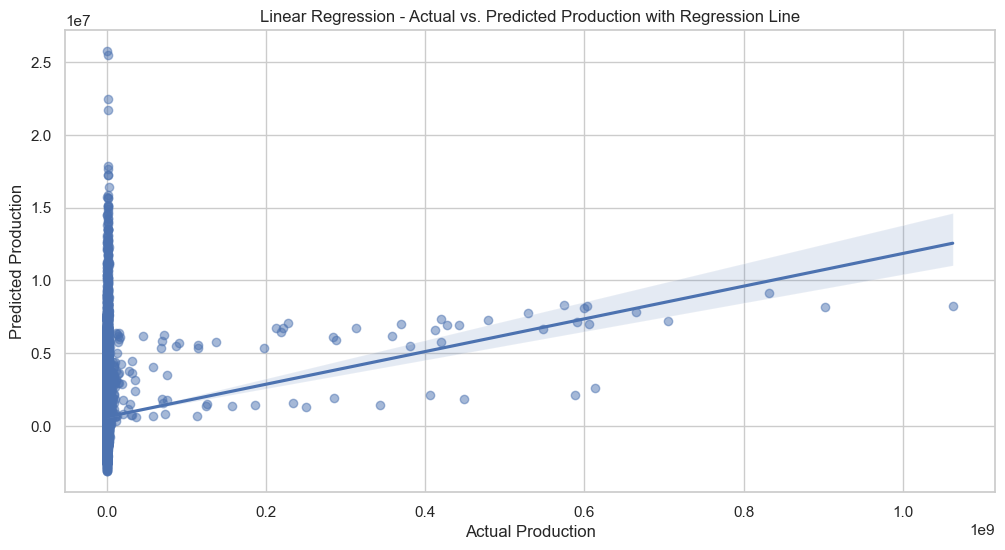

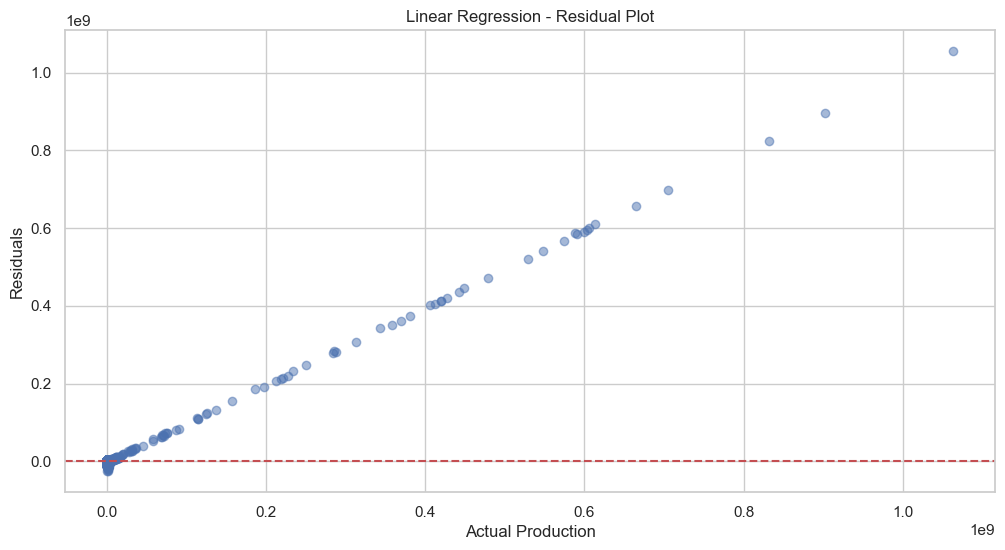

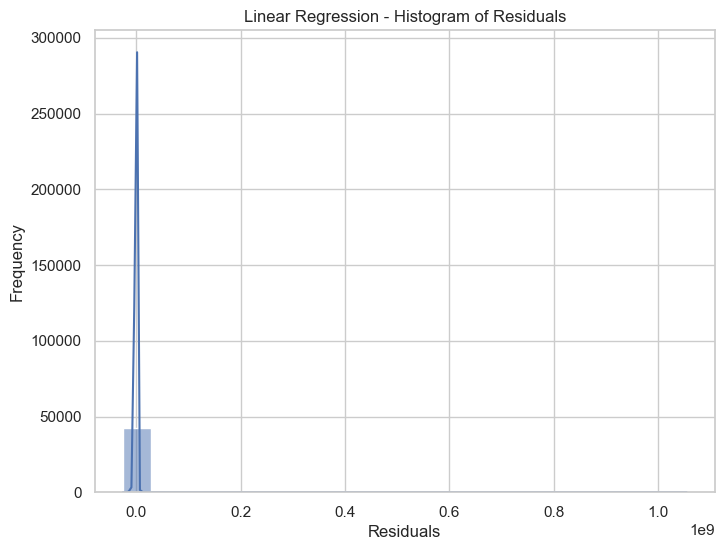

C:\Users\dgoya\AppData\Local\Temp\ipykernel_11000\3173735560.py:40: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(actual_vs_predicted["Production"], label="Actual Production", shade=True)
C:\Users\dgoya\AppData\Local\Temp\ipykernel_11000\3173735560.py:41: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(actual_vs_predicted["prediction"], label="Predicted Production", shade=True)


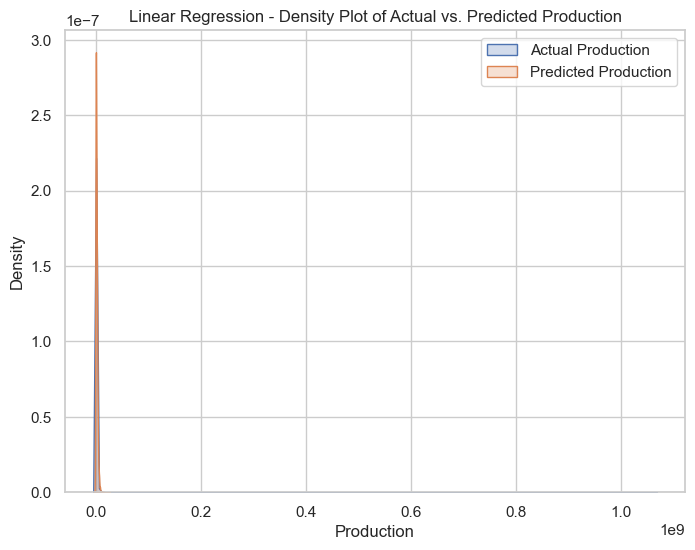

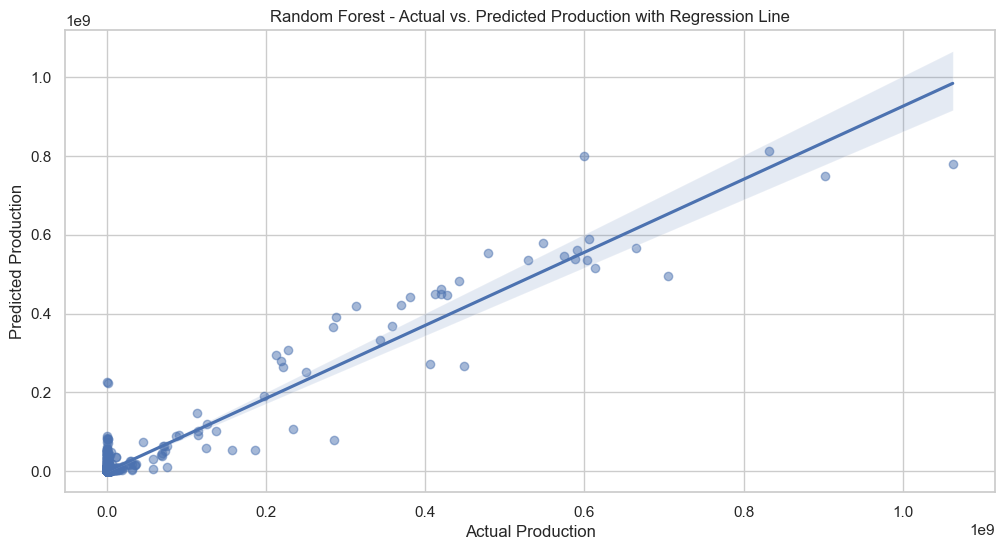

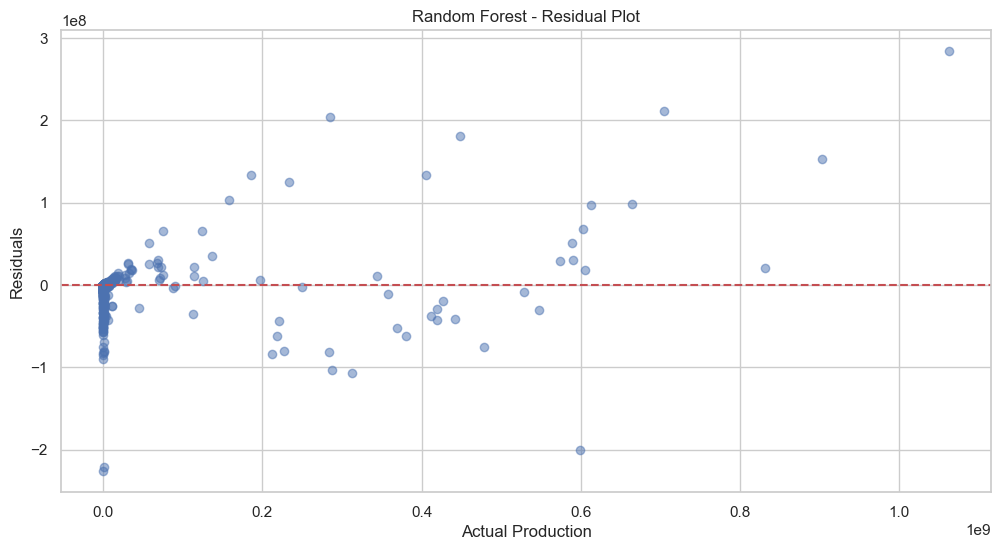

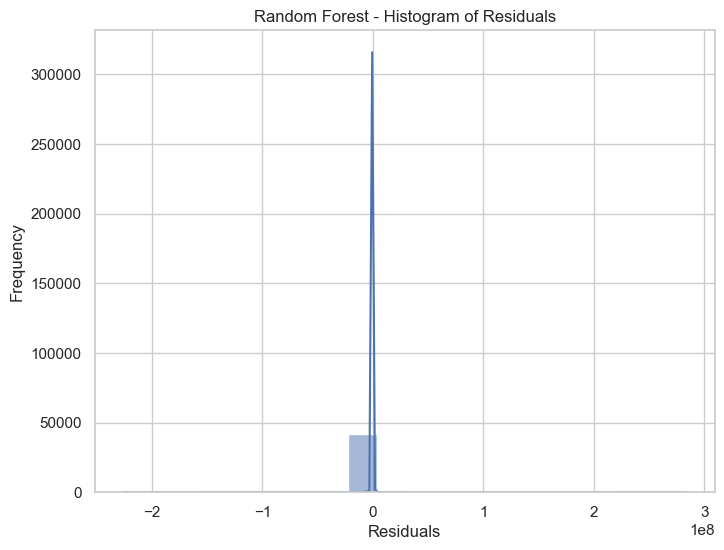

C:\Users\dgoya\AppData\Local\Temp\ipykernel_11000\3173735560.py:40: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(actual_vs_predicted["Production"], label="Actual Production", shade=True)
C:\Users\dgoya\AppData\Local\Temp\ipykernel_11000\3173735560.py:41: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(actual_vs_predicted["prediction"], label="Predicted Production", shade=True)


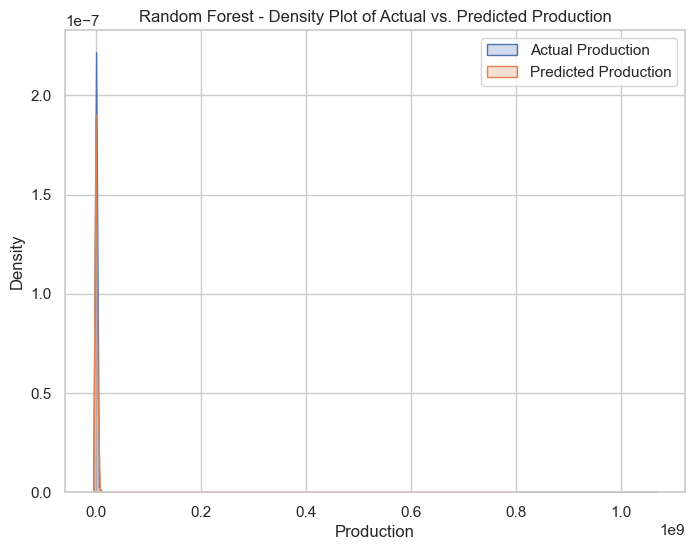

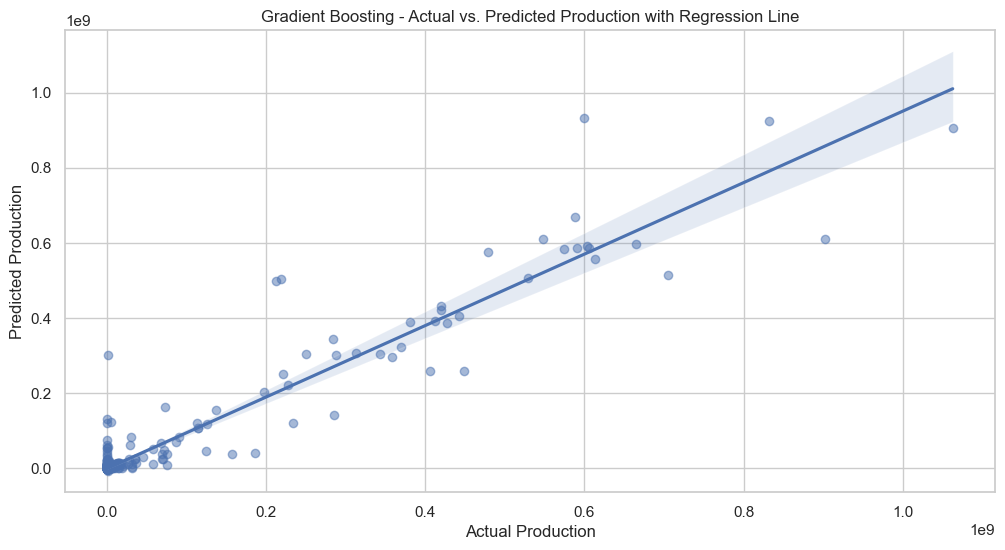

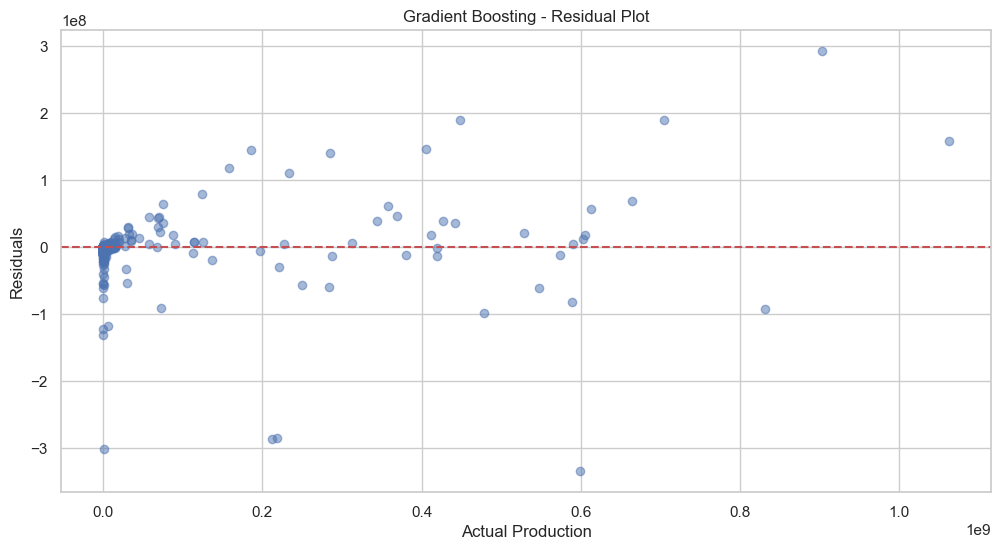

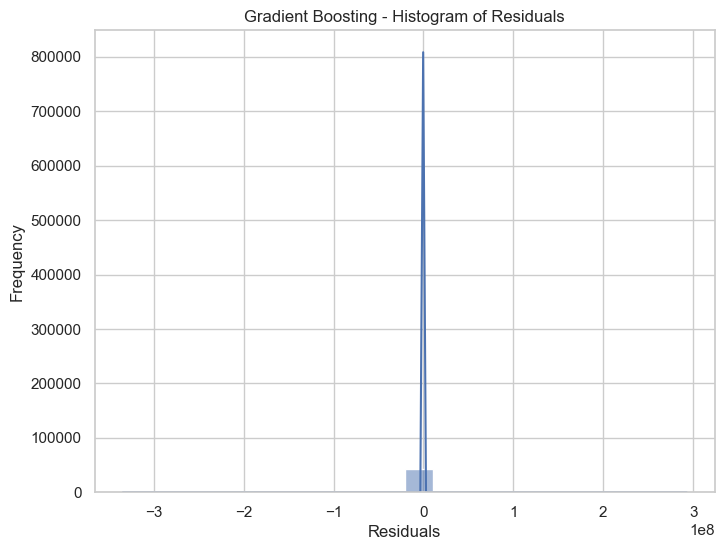

C:\Users\dgoya\AppData\Local\Temp\ipykernel_11000\3173735560.py:40: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(actual_vs_predicted["Production"], label="Actual Production", shade=True)
C:\Users\dgoya\AppData\Local\Temp\ipykernel_11000\3173735560.py:41: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(actual_vs_predicted["prediction"], label="Predicted Production", shade=True)


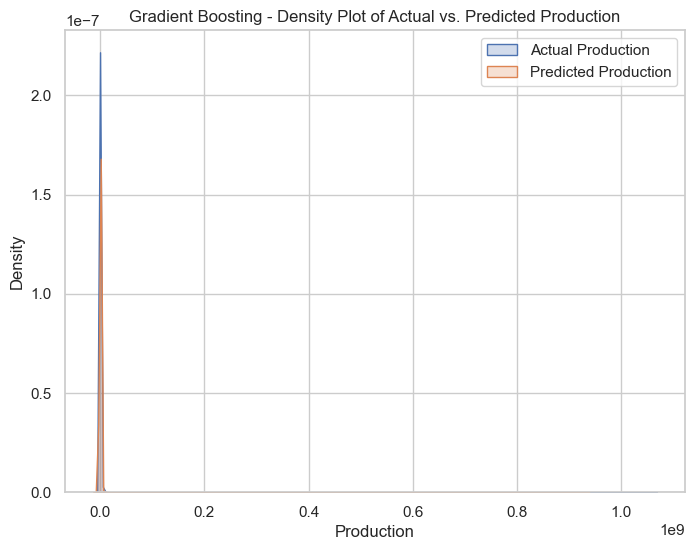

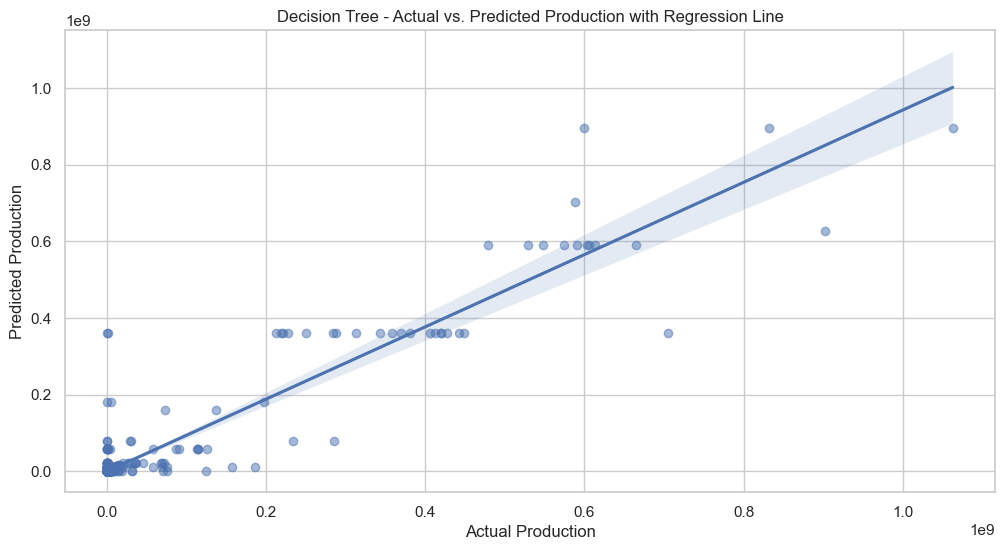

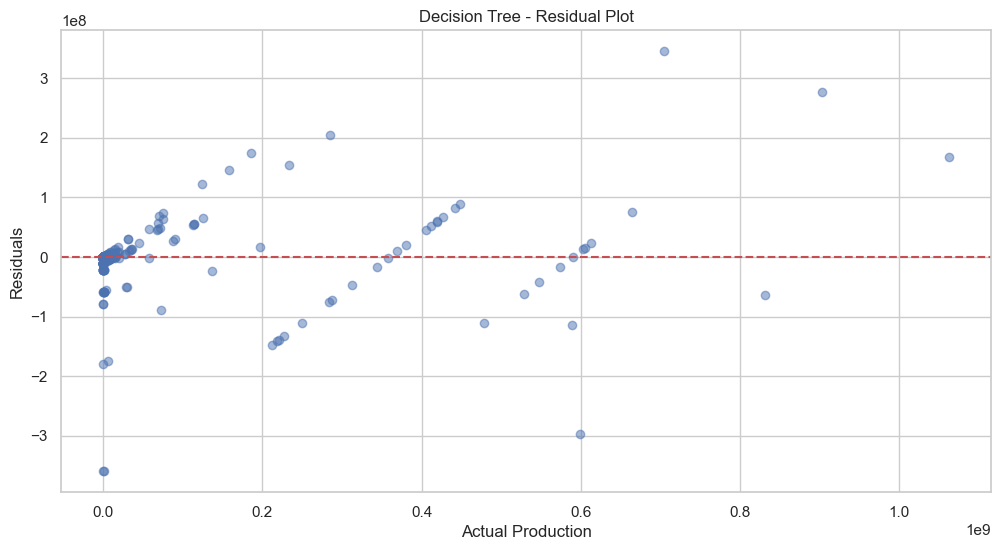

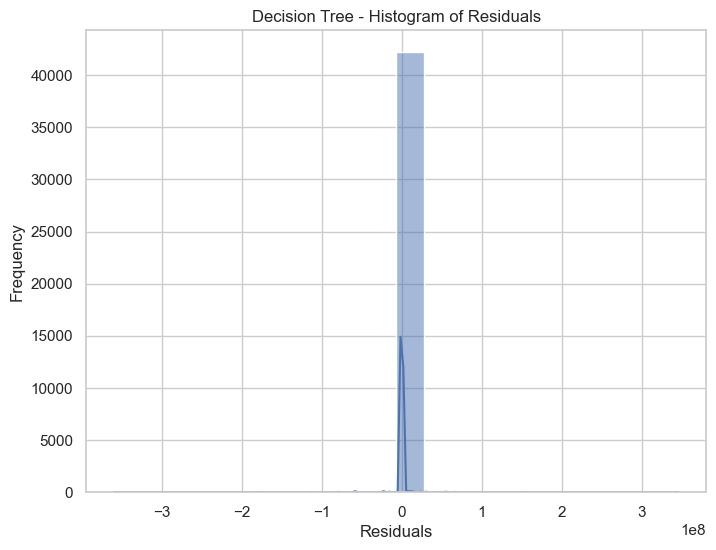

C:\Users\dgoya\AppData\Local\Temp\ipykernel_11000\3173735560.py:40: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(actual_vs_predicted["Production"], label="Actual Production", shade=True)
C:\Users\dgoya\AppData\Local\Temp\ipykernel_11000\3173735560.py:41: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(actual_vs_predicted["prediction"], label="Predicted Production", shade=True)


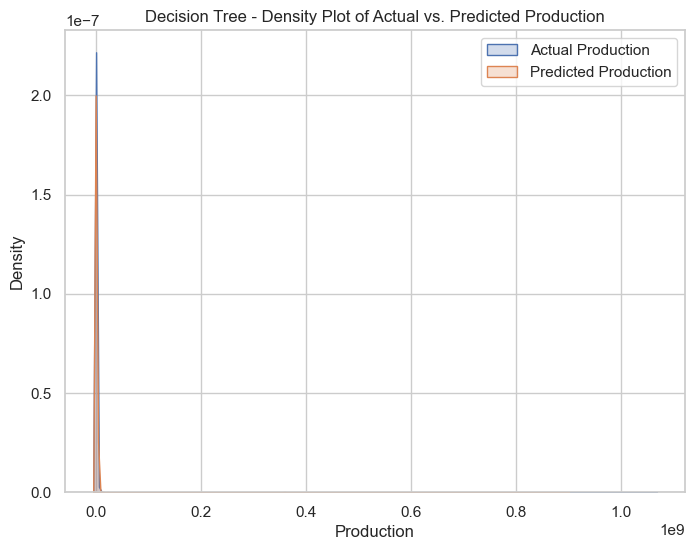

In [35]:
import seaborn as sns

# Function to create additional plots
def create_advanced_plots(predictions, model_name):
    actual_vs_predicted = predictions.select("Production", "prediction").toPandas()

    # Scatter plot with regression line
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))

    sns.regplot(x="Production", y="prediction", data=actual_vs_predicted, scatter_kws={'alpha':0.5})
    plt.xlabel("Actual Production")
    plt.ylabel("Predicted Production")
    plt.title(f"{model_name} - Actual vs. Predicted Production with Regression Line")
    plt.grid(True)
    plt.show()

    # Residual plot
    plt.figure(figsize=(12, 6))
    residuals = actual_vs_predicted["Production"] - actual_vs_predicted["prediction"]
    plt.scatter(actual_vs_predicted["Production"], residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel("Actual Production")
    plt.ylabel("Residuals")
    plt.title(f"{model_name} - Residual Plot")
    plt.grid(True)
    plt.show()

    # Histogram of residuals
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, bins=20, kde=True)
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.title(f"{model_name} - Histogram of Residuals")
    plt.grid(True)
    plt.show()

    # Density plots
    plt.figure(figsize=(8, 6))
    sns.kdeplot(actual_vs_predicted["Production"], label="Actual Production", shade=True)
    sns.kdeplot(actual_vs_predicted["prediction"], label="Predicted Production", shade=True)
    plt.xlabel("Production")
    plt.ylabel("Density")
    plt.title(f"{model_name} - Density Plot of Actual vs. Predicted Production")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function for each model
create_advanced_plots(linear_reg_predictions, "Linear Regression")
create_advanced_plots(rf_predictions, "Random Forest")
create_advanced_plots(gbt_predictions, "Gradient Boosting")
create_advanced_plots(dt_predictions, "Decision Tree")